# Expedia hotel recommendations with Apache Spark

The size of the train set is 3.8 GB, with more than 37 million samples! That is why I will be using Pyspark instead of our favorite Pandas! When possible for visualization I will be using toPandas() command to convert pyspark dataframes to pandas. 

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from pyspark.sql.functions import count
import seaborn as sns
from pyspark.sql import functions as F
from sklearn import metrics

In [3]:
spark = SparkSession.builder.getOrCreate()

## 1. Import and Explore

### 1.1. Import:

In [186]:
train = spark.read.csv('s3://test-bucket-for-tutorial/train.csv', header=True)
test = spark.read.csv('s3://test-bucket-for-tutorial/test.csv', header=True)

### 1.2 Explore

What attriutes we have?

In [4]:
train.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- site_name: string (nullable = true)
 |-- posa_continent: string (nullable = true)
 |-- user_location_country: string (nullable = true)
 |-- user_location_region: string (nullable = true)
 |-- user_location_city: string (nullable = true)
 |-- orig_destination_distance: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- is_mobile: string (nullable = true)
 |-- is_package: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: string (nullable = true)
 |-- srch_children_cnt: string (nullable = true)
 |-- srch_rm_cnt: string (nullable = true)
 |-- srch_destination_id: string (nullable = true)
 |-- srch_destination_type_id: string (nullable = true)
 |-- is_booking: string (nullable = true)
 |-- cnt: string (nullable = true)
 |-- hotel_continent: string (nullable = true)
 |-- hotel_country: string (nullable = true)
 

In [5]:
test.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_time: string (nullable = true)
 |-- site_name: string (nullable = true)
 |-- posa_continent: string (nullable = true)
 |-- user_location_country: string (nullable = true)
 |-- user_location_region: string (nullable = true)
 |-- user_location_city: string (nullable = true)
 |-- orig_destination_distance: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- is_mobile: string (nullable = true)
 |-- is_package: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: string (nullable = true)
 |-- srch_children_cnt: string (nullable = true)
 |-- srch_rm_cnt: string (nullable = true)
 |-- srch_destination_id: string (nullable = true)
 |-- srch_destination_type_id: string (nullable = true)
 |-- hotel_continent: string (nullable = true)
 |-- hotel_country: string (nullable = true)
 |-- hotel_market: string (nullable = true)


How many samples does the train data include?

In [6]:
n_train = train.count()
print(n_train)

37670293


Quite big! Around 38 millions!

How many samples does the test data include? 

In [7]:
test.count()

2528243

**First Visualization**:

To see the first five rows of the train set, it is possible to use train.head(5) or train.show(5) (slightly better visualization), but still it can be quite hard to get a sense of the data. Instead, I use Pandas:

In [183]:
pd.DataFrame(train.head(5), columns=train.columns)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,hotel_market,srch_ci_yr,srch_ci_mn,srch_ci_dy,srch_ci_dyOfWeek,srch_co_dy,srch_co_dyOfWeek,len_of_stay,is_weekend,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,12,0,1,9,...,628,2014,8,27,4,31,1,4,0,1
1,2014-08-11 08:22:12,2,3,66,348,48862,12,0,1,9,...,628,2014,8,29,6,2,3,4,1,1
2,2014-08-11 08:24:33,2,3,66,348,48862,12,0,0,9,...,628,2014,8,29,6,2,3,4,1,1
3,2014-08-09 18:05:16,2,3,66,442,35390,93,0,0,3,...,1457,2014,11,23,1,28,6,5,1,80
4,2014-08-09 18:08:18,2,3,66,442,35390,93,0,0,3,...,1457,2014,11,23,1,28,6,5,1,21


Similarly, for .describe():

In [9]:
train.describe().toPandas()

,summary,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,count,37670293,37670293,37670293,37670293,37670293,37670293,24145292,37670293,37670293,...,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293
1,mean,None,9.795271329585889,2.6804730188851997,86.10880194109454,308.4060117610447,27753.044729330883,1970.0900267207285,604451.7531778422,0.1349265056154461,...,0.3321221579030458,1.1126628083301608,14441.090543760836,2.5822799148389954,0.07965674702875288,1.4833839227106622,3.1563047837190967,81.29685165974153,600.461883638654,49.80860501934509
2,stddev,None,11.9675435665128,0.7480393482506577,59.24310334783878,208.44374973856722,16782.553195680346,2232.4424303904275,350617.4620408585,0.34164505966916764,...,0.7314980986397146,0.45911549963856946,11066.302332627309,2.153018959399955,0.2707610600283715,1.2197755786558424,1.6231886782105662,56.171188062887815,511.73912727922396,28.915950805004293
3,min,2013-01-07 00:00:02,10,0,0,0,0,0.0056,0,0,...,0,0,0,0,0,1,0,0,0,0
4,max,2014-12-31 23:59:59,9,4,99,999,9998,9999.9984,999999,1,...,9,8,9999,9,1,99,6,99,999,99


What are the feature types? 

In [10]:
train.dtypes

[('date_time', 'string'),
 ('site_name', 'string'),
 ('posa_continent', 'string'),
 ('user_location_country', 'string'),
 ('user_location_region', 'string'),
 ('user_location_city', 'string'),
 ('orig_destination_distance', 'string'),
 ('user_id', 'string'),
 ('is_mobile', 'string'),
 ('is_package', 'string'),
 ('channel', 'string'),
 ('srch_ci', 'string'),
 ('srch_co', 'string'),
 ('srch_adults_cnt', 'string'),
 ('srch_children_cnt', 'string'),
 ('srch_rm_cnt', 'string'),
 ('srch_destination_id', 'string'),
 ('srch_destination_type_id', 'string'),
 ('is_booking', 'string'),
 ('cnt', 'string'),
 ('hotel_continent', 'string'),
 ('hotel_country', 'string'),
 ('hotel_market', 'string'),
 ('hotel_cluster', 'string')]

The read.csv() function of pyspark read all the features as string! So, we convert them appropriately:

In [11]:
print(train.columns, "\n")
print("The train set has", len(train.columns), "columns.")

['date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster'] 

The train set has 24 columns.


In [187]:
int_columns = ['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 
               'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
               'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 
               'hotel_market', 'hotel_cluster']
float_columns = ['orig_destination_distance']
date_columns = ['date_time', 'srch_ci', 'srch_co']

In [188]:
for i in range(len(int_columns)):
    train = train.withColumn(int_columns[i], train[int_columns[i]].astype('int'))
for i in range(len(float_columns)):
    train = train.withColumn(float_columns[i], train[float_columns[i]].astype('float'))

In [189]:
int_columns = ['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 
               'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
               'srch_destination_id', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 
               'hotel_market']
float_columns = ['orig_destination_distance']
date_columns = ['date_time', 'srch_ci', 'srch_co']

In [190]:
for i in range(len(int_columns)):
    test = test.withColumn(int_columns[i], test[int_columns[i]].astype('int'))
for i in range(len(float_columns)):
    test = test.withColumn(float_columns[i], test[float_columns[i]].astype('float'))

Let's now check the types:

In [14]:
train.dtypes

[('date_time', 'string'),
 ('site_name', 'int'),
 ('posa_continent', 'int'),
 ('user_location_country', 'int'),
 ('user_location_region', 'int'),
 ('user_location_city', 'int'),
 ('orig_destination_distance', 'float'),
 ('user_id', 'int'),
 ('is_mobile', 'int'),
 ('is_package', 'int'),
 ('channel', 'int'),
 ('srch_ci', 'string'),
 ('srch_co', 'string'),
 ('srch_adults_cnt', 'int'),
 ('srch_children_cnt', 'int'),
 ('srch_rm_cnt', 'int'),
 ('srch_destination_id', 'int'),
 ('srch_destination_type_id', 'int'),
 ('is_booking', 'int'),
 ('cnt', 'int'),
 ('hotel_continent', 'int'),
 ('hotel_country', 'int'),
 ('hotel_market', 'int'),
 ('hotel_cluster', 'int')]

**How many are really booking?**

In [15]:
train.where(train.is_booking == 1).count()

3000693

**Only around 3 millions of the 38 millions data 'booked', and the rest where only a click! So, what is the chance of booking when click?**

In [16]:
print(train.where(train.is_booking == 1).count() / train[train.is_booking.isNotNull()].count() * 100, '%')

7.965674702875288 %


So, only **8%** of the train data is booking and the rest are clicks! 

**How many distinct user location country, city, hotel country, hotel cluster, users we have?**

In [17]:
print("train data summary:\n",
      train.select('user_location_country').distinct().count(), "user countries\n", 
      train.select('user_location_city').distinct().count(), "user cities\n", 
      train.select('hotel_country').distinct().count(), "hotel countries\n",
      train.select('hotel_cluster').distinct().count(), "hotel clusters\n",
      train.select('srch_destination_type_id').distinct().count(), "search destination types\n", 
      train.select('user_id').distinct().count(), "distinct users")

train data summary:
 237 user countries
 50447 user cities
 213 hotel countries
 100 hotel clusters
 10 search destination types
 1198786 distinct users


So only ~1.2 millions users generate the ~38 millions logs!

Are there any users in common in train-test sets? 

Since there exists only 1.2 different users and average cnt (number of clicks in a Session) is only ~1.5, that would mean that the logs of the same users has been recorded in different sessions or different srch_destination_ids. 

In [18]:
pd.DataFrame(train.head(5), columns=train.columns)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.264160,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.264160,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.264160,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.193176,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.625916,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [20]:
test.describe().toPandas()

,summary,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,count,2528243,2528243,2528243,2528243,2528243,2528243,2528243,1680782,2528243,...,2528222,2528226,2528243,2528243,2528243,2528243,2528243,2528243,2528243,2528243
1,mean,1264121.0,None,9.70966556616591,2.697412788248598,85.51611929707705,317.0340683233376,27862.17806318459,1686.3979638184105,602645.9257690024,...,None,None,1.958126651591639,0.25074132510205704,1.117409995795499,16568.621168139296,2.941701806353266,3.022614914784694,81.25454277931354,646.4925847713214
2,stddev,729841.0326509465,None,12.271834283602896,0.7651287624994623,56.73879902333156,208.28338881273413,16687.877645606164,2197.361433047482,346965.11778565275,...,None,None,0.8980415286253776,0.6754566222733871,0.4615009555032746,12805.019853860984,2.282005929487735,1.6748793299399136,55.07528338943058,504.65298547297846
3,min,0,2015-01-08 00:00:35,0,0,0,0,0,0.0056,0,...,2015-01-04,2015-01-08,0,0,0,10,1,0,0,0
4,max,999999,2015-12-31 23:58:47,9,4,99,999,9999,9999.9851,999999,...,2161-10-00,2017-04-30,9,9,8,9999,9,6,99,999


### 1.3 Missing data

Print out the missing data for all columns:

In [21]:
for c in train.columns:
    print(c, ' ', train.where(col(c).isNull()).count())

date_time   0
site_name   0
posa_continent   0
user_location_country   0
user_location_region   0
user_location_city   0
orig_destination_distance   13525001
user_id   0
is_mobile   0
is_package   0
channel   0
srch_ci   47083
srch_co   47084
srch_adults_cnt   0
srch_children_cnt   0
srch_rm_cnt   0
srch_destination_id   0
srch_destination_type_id   0
is_booking   0
cnt   0
hotel_continent   0
hotel_country   0
hotel_market   0
hotel_cluster   0


There exists three features with null values, namely orig_destination_distance, search check in, and search check out. Since, the proportion of missing srch_ci and srch_co is very small compared to the total data (only ~47000 out of 37 million!) we drop the rows with missing srch_ci or srch_co. 

In [22]:
for c in test.columns:
    print(c , ' ', test.where(col(c).isNull()).count())

id   0
date_time   0
site_name   0
posa_continent   0
user_location_country   0
user_location_region   0
user_location_city   0
orig_destination_distance   847461
user_id   0
is_mobile   0
is_package   0
channel   0
srch_ci   21
srch_co   17
srch_adults_cnt   0
srch_children_cnt   0
srch_rm_cnt   0
srch_destination_id   0
srch_destination_type_id   0
hotel_continent   0
hotel_country   0
hotel_market   0


Can you get year, month, day of month, day of week of the checkin and checkout date?

In [191]:
train = train.withColumn('srch_ci_yr', F.year(train['srch_ci']))
train = train.withColumn('srch_ci_mn', F.month(train['srch_ci']))
train = train.withColumn('srch_ci_dy', F.dayofmonth(train['srch_ci']))
train = train.withColumn('srch_ci_dyOfWeek', F.dayofweek(train['srch_ci']))

In [192]:
train = train.withColumn('srch_co_dy', F.dayofmonth(train['srch_co']))
train = train.withColumn('srch_co_dyOfWeek', F.dayofweek(train['srch_co']))

Calculate the `len_of_stay` as a new feature. Normally it should be correlated with the `hotel_cluster`.

In [193]:
train = train.withColumn('len_of_stay', F.datediff(start = train['srch_ci'], end = train['srch_co']))

In [194]:
makePos = F.udf(lambda x: x if x > 0 else 1)

In [195]:
train = train.withColumn('len_of_stay', makePos(train['len_of_stay']).astype("int"))

In [94]:
train.where(train.len_of_stay < 0).count()

0

In [196]:
def head2pd(df):
    return pd.DataFrame(df.head(5), columns = df.columns)

Can you define `is_weekend` as a new feature?

In [197]:
ch_expression = ((train['srch_ci_dyOfWeek'] == 6) | (train['srch_ci_dyOfWeek'] == 7) | (train['srch_co_dyOfWeek'] == 6) | (train['srch_co_dyOfWeek'] == 7))
train = train.withColumn('is_weekend', ch_expression.astype("int"))
head2pd(train.withColumn('is_weekend', ch_expression.astype("int")))

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,hotel_market,hotel_cluster,srch_ci_yr,srch_ci_mn,srch_ci_dy,srch_ci_dyOfWeek,srch_co_dy,srch_co_dyOfWeek,len_of_stay,is_weekend
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.264160,12,0,1,...,628,1,2014,8,27,4,31,1,4,0
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.264160,12,0,1,...,628,1,2014,8,29,6,2,3,4,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.264160,12,0,0,...,628,1,2014,8,29,6,2,3,4,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.193176,93,0,0,...,1457,80,2014,11,23,1,28,6,5,1
4,2014-08-09 18:08:18,2,3,66,442,35390,913.625916,93,0,0,...,1457,21,2014,11,23,1,28,6,5,1


In [284]:
head2pd(test)

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [198]:
test = test.na.fill({'srch_ci' : '1990-01-01', 'srch_co' : '1990-01-02'}) # toCheck

In [199]:
test = test.withColumn('srch_ci_mn', F.month(test['srch_ci']))

In [261]:
test.where(test.srch_ci_mn.isNull()).count()

1

Suprisingly there is one null element in srch_ci_mn, we explore why:

In [264]:
head2pd(test.where(test.srch_ci_mn.isNull()))[['id', 'srch_ci', 'srch_co']]

,id,srch_ci,srch_co
0,312920,2161-10-00,2016-01-22


So, the srch_ci date has a wrong form. We modify the checkin date to a day less than checkout:

In [200]:
myFun = F.udf(lambda x: '2016-01-21' if (x == '2161-10-00') else x)

In [201]:
test = test.withColumn('srch_ci', myFun(test['srch_ci']))

In [202]:
test = test.withColumn('srch_ci_mn', F.month(test['srch_ci']))

In [269]:
test.where(test.srch_ci_mn.isNull()).count()

0

In [203]:
test = test.withColumn('srch_ci_dy', F.dayofmonth(test['srch_ci']))

In [204]:
test = test.withColumn('srch_ci_dyOfWeek', F.dayofweek(test['srch_ci']))
test = test.withColumn('srch_co_dyOfWeek', F.dayofweek(test['srch_co']))
test = test.withColumn('len_of_stay', F.datediff(start=test['srch_ci'], end = test['srch_co']))
ch_expression = ((test['srch_ci_dyOfWeek'] == 6) | (test['srch_ci_dyOfWeek'] == 7) | (test['srch_co_dyOfWeek'] == 6) | (test['srch_co_dyOfWeek'] == 7))
test = test.withColumn('is_weekend', ch_expression.astype("int"))

In [205]:
test = test.withColumn('len_of_stay', makePos(test['len_of_stay']).astype("int"))

We put the hotel_cluster as the last column:

In [206]:
train = train.select(train.columns[0:23] + train.columns[24:] + ['hotel_cluster'])

In [21]:
train.columns

['date_time',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_ci',
 'srch_co',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'srch_ci_yr',
 'srch_ci_mn',
 'srch_ci_dy',
 'srch_ci_dyOfWeek',
 'srch_co_dy',
 'srch_co_dyOfWeek',
 'len_of_stay',
 'is_weekend',
 'hotel_cluster']

In [207]:
train_bkp = train

In [208]:
train = train.where(col('srch_ci').isNotNull() & col('srch_co').isNotNull())

In [48]:
train_head = pd.DataFrame(train.head(5), columns=train.columns)

In [209]:
train = train.drop('orig_destination_distance')
test = test.drop('orig_destination_distance')

In [23]:
train.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_id: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: integer (nullable = true)
 |-- hotel_market: integer (nullable = t

In [53]:
for c in train.columns:
    print(c, ' ', train.where(col(c).isNull()).count())

date_time   0
site_name   0
posa_continent   0
user_location_country   0
user_location_region   0
user_location_city   0
user_id   0
is_mobile   0
is_package   0
channel   0
srch_ci   0
srch_co   0
srch_adults_cnt   0
srch_children_cnt   0
srch_rm_cnt   0
srch_destination_id   0
srch_destination_type_id   0
is_booking   0
cnt   0
hotel_continent   0
hotel_country   0
hotel_market   0
srch_ci_yr   0
srch_ci_dy   0
srch_ci_dyOfWeek   0
hotel_cluster   0
srch_co_dy   0
srch_co_dyOfWeek   0
hotel_cluster   0


## 2. Feature engineering

For Exploratory Data Analysis (EDA), working with the large data, and especially visuallizing the data is almost impossible. Instead we will be using a random sample of 1 % of the data for EDA. 

In [26]:
sample_train_pd = train.sample(False, 0.01).toPandas()
# only the users with is_booking = 1
sample_trainB_pd = train.where(train.is_booking == 1).sample(False, 0.01).toPandas()
sample_trainB_pd['is_booking'] = 1
# users with is_booking = 0
sample_trainNB_pd = train.where(train.is_booking == 0).sample(False, 0.01).toPandas()
sample_trainNB_pd['is_booking'] = 0

In [306]:
test_pd = test.sample(False, 0.5).toPandas()

The size of the sampled train data is:

In [215]:
print("The ratio of booking to all in the sampled train data is", len(sample_train_pd.loc[sample_train_pd['is_booking'] == 1]) / len(sample_train_pd) * 100, " %.")

The ratio of booking to all in the sampled train data is 7.992992298995243  %.


In [216]:
print("The ration of booking to all in all train data is", train.where(train.is_booking == 1).count() / train[train.is_booking.isNotNull()].count() * 100, '%.')

The ration of booking to all in all train data is 7.975644286551345 %.


In [ ]:
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.hist(sample_trainB_pd['hotel_cluster'], bins = range(0, 99), density = True)
plt.title('Only clicks data')
plt.xlabel('Hotel Clusters')
plt.subplot(1, 2, 2)
plt.hist(sample_trainNB_pd['hotel_cluster'], bins = range(0, 99), density= True)
plt.title('Only booking data')
plt.xlabel('Hotel Clusters')

The distribution of the selected hotel clusters in the only-book-data is different from only-click-data. Given that the test data is only on booking data, the question is should we only use only-book-data? To better answer this question, we do a more systematic comparison between only-book and only-click data.

In [ ]:
hotel_cluster_hist_B = np.histogram(sample_trainB_pd['hotel_cluster'], bins = range(99), density=True)
hotel_cluster_hist_NB = np.histogram(sample_trainNB_pd['hotel_cluster'], bins = range(99), density = True)

In [ ]:
clusterB = sample_trainB_pd['hotel_cluster'].value_counts(normalize = True).sort_index()
clusterNB = sample_trainNB_pd['hotel_cluster'].value_counts(normalize = True).sort_index()

plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(clusterB, '.-')
plt.plot(clusterNB, '.-')
plt.subplot(1, 2, 2)
plt.plot((clusterNB - clusterB) / clusterB * 100, '.-')

In [190]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(20, 18))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

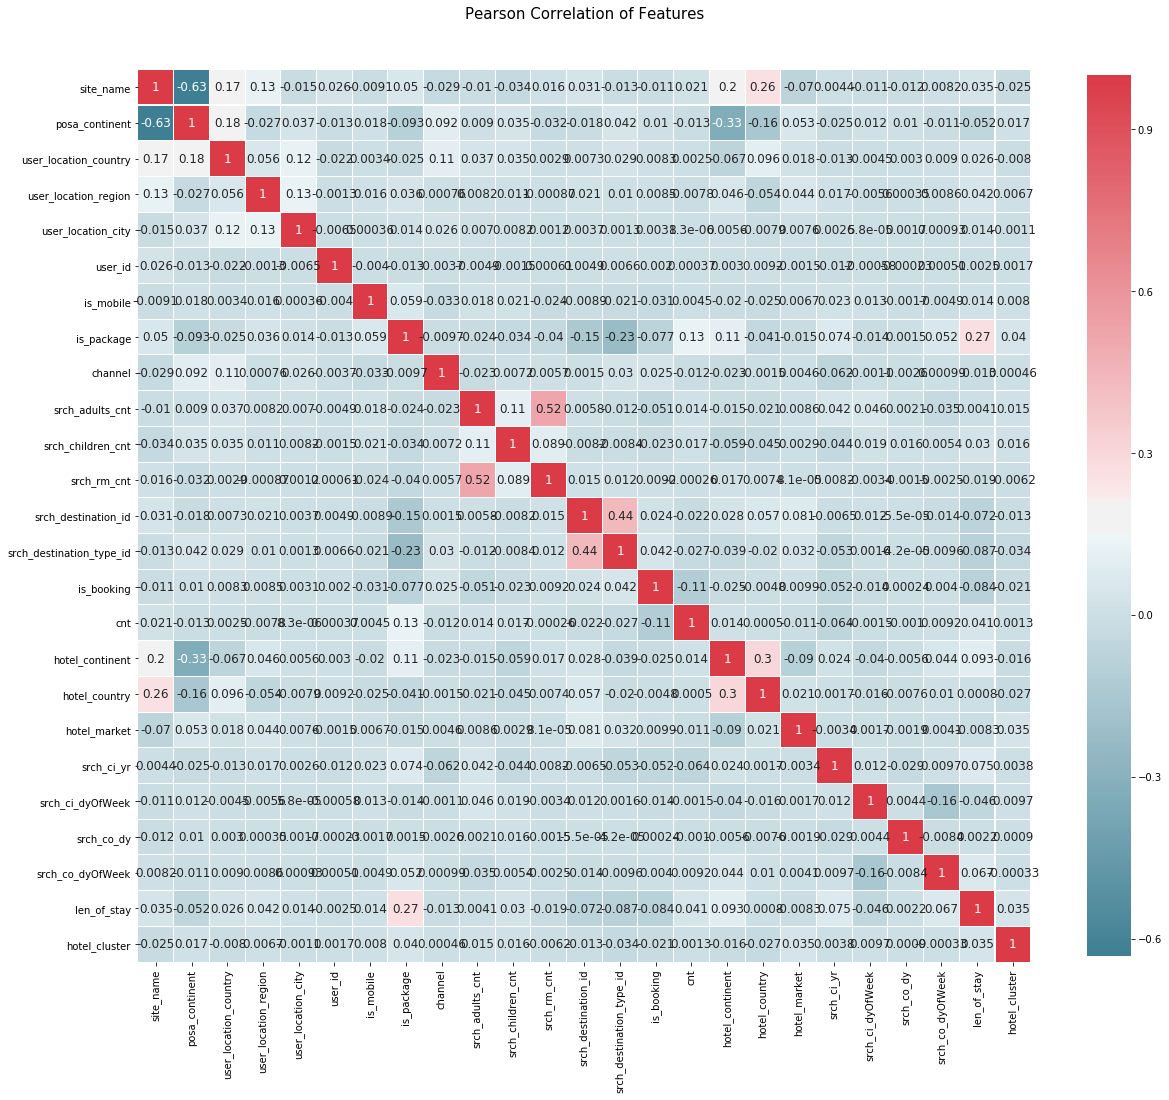

In [207]:
correlation_heatmap(sample_train_pd)

In [257]:
corr_matrix = sample_train_pd.corr()

In [258]:
corr_matrix['hotel_cluster']

site_name                  -0.021873
posa_continent              0.014574
user_location_country      -0.011725
user_location_region        0.006497
user_location_city          0.002921
user_id                     0.001836
is_mobile                   0.010302
is_package                  0.040487
channel                     0.001300
srch_adults_cnt             0.012500
srch_children_cnt           0.014682
srch_rm_cnt                -0.006581
srch_destination_id        -0.011283
srch_destination_type_id   -0.032551
is_booking                 -0.021283
cnt                         0.004836
hotel_continent            -0.013322
hotel_country              -0.026060
hotel_market                0.036136
srch_ci_yr                  0.008638
srch_ci_dyOfWeek            0.012450
srch_co_dy                  0.000381
srch_co_dyOfWeek            0.002530
len_of_stay                 0.038573
is_weekend                  0.008765
hotel_cluster               1.000000
Name: hotel_cluster, dtype: float64

There is little correlation between any of the features with hotel cluster. The **is_package** feature has the maximum correlation with hotel cluster. Next are the **hotel_market** and **srch_destination_type_id**. 

**Correlation with hotel cluster in only booking data**

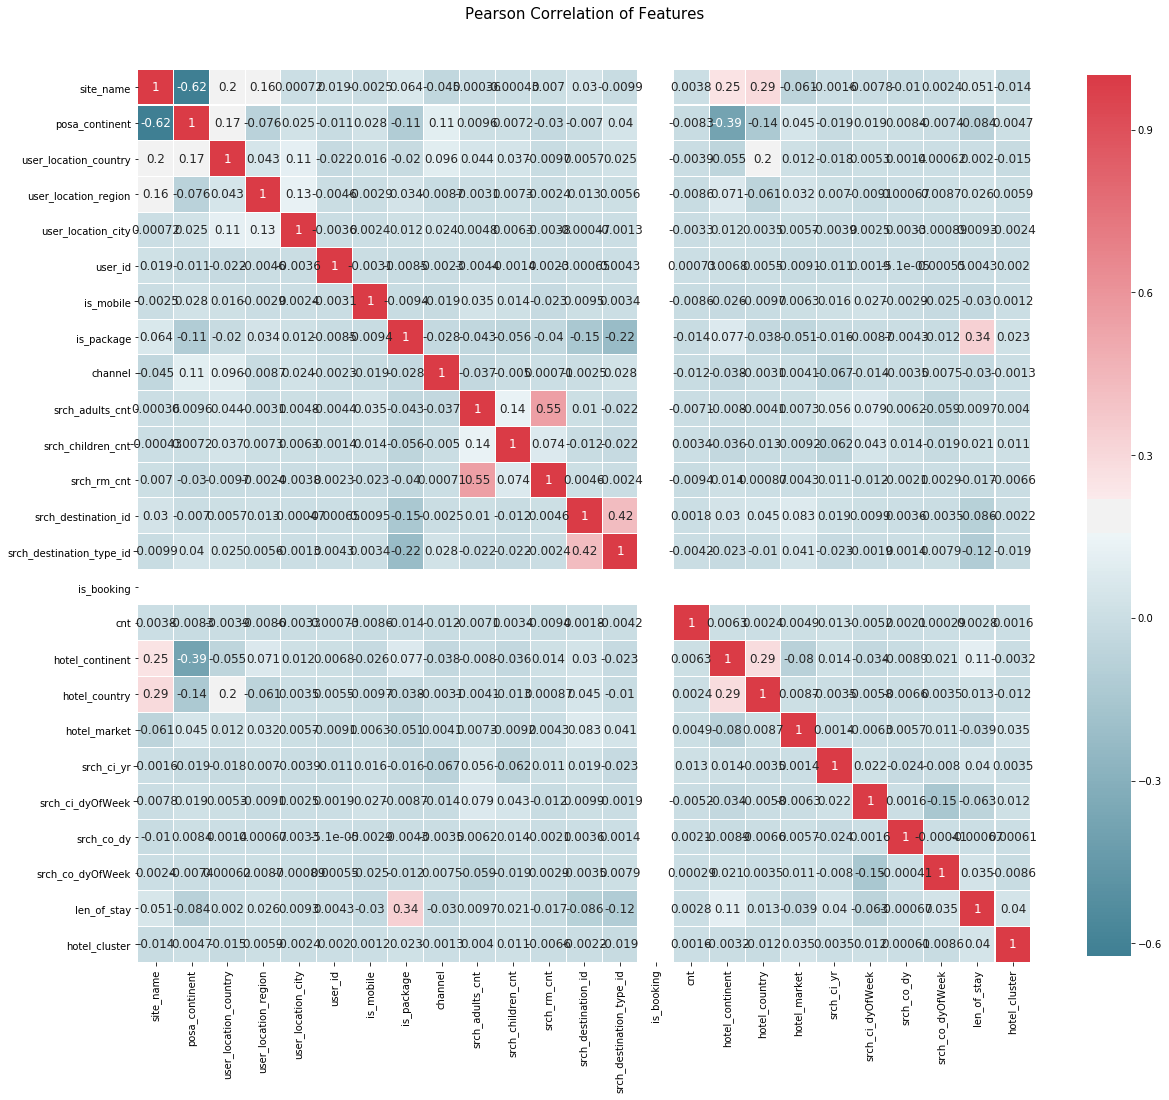

In [210]:
correlation_heatmap(sample_trainB_pd)

In [118]:
corr_matrix_B = sample_trainB_pd.corr()

In [120]:
corr_matrix_B['hotel_cluster'].fillna(0, inplace = True)

In [261]:
corr_matrix_B['hotel_cluster']

site_name                  -0.009846
posa_continent             -0.000273
user_location_country      -0.012490
user_location_region        0.002292
user_location_city         -0.001354
user_id                     0.003126
is_mobile                  -0.000580
is_package                  0.020250
channel                     0.005426
srch_adults_cnt             0.003854
srch_children_cnt           0.012641
srch_rm_cnt                -0.007734
srch_destination_id        -0.001543
srch_destination_type_id   -0.017066
is_booking                  0.000000
cnt                         0.001244
hotel_continent            -0.002397
hotel_country              -0.011289
hotel_market                0.031757
srch_ci_yr                  0.004338
srch_ci_dyOfWeek            0.010497
srch_co_dy                  0.000121
srch_co_dyOfWeek           -0.007691
len_of_stay                 0.041089
is_weekend                  0.010501
hotel_cluster               1.000000
Name: hotel_cluster, dtype: float64

In [121]:
np.sort(corr_matrix_B['hotel_cluster'])

array([-2.77572381e-02, -1.83159074e-02, -1.06130571e-02, -1.02296489e-02,
       -8.71847564e-03, -6.28995490e-03, -5.00985537e-03, -4.41028928e-03,
       -3.55125198e-03, -2.72350370e-03, -1.00582398e-03,  0.00000000e+00,
        5.34943146e-04,  2.23791097e-03,  2.29101880e-03,  2.73533655e-03,
        5.16661445e-03,  5.59949320e-03,  7.20085160e-03,  7.20887031e-03,
        9.92772000e-03,  1.12049363e-02,  1.39979978e-02,  1.53255567e-02,
        2.34581954e-02,  3.59127204e-02,  4.50020420e-02,  1.00000000e+00])

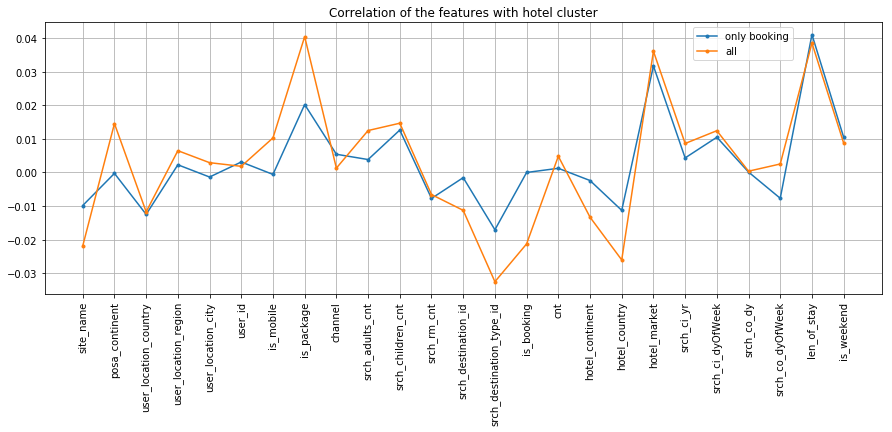

In [262]:
plt.figure(figsize=(15, 5))
plt.plot(corr_matrix_B['hotel_cluster'][0:-1], '.-', label='only booking')
plt.xticks(rotation=90)
plt.plot(corr_matrix['hotel_cluster'][0:-1], '.-', label = 'all')
plt.legend(bbox_to_anchor = (0.9, 1))
plt.title('Correlation of the features with hotel cluster')
plt.grid()

From the chart above, it is clear that the **hotel_market** has the highest correlation with the hotel_cluster both in only-booking data and all data. However, **is_package** has much less correlation with hotel_cluster in only-booking data compared to all data. This shows that is_package == 1 makes the users click way more that ususal but not neccessarily book. The above graph makes me come to the conclusion to separate the only-booking data from the click data; run two machine learning predictions on both and eventually do a linear combination/voting of the two predictions with a small weight on the click predictions. 

The **length of stay** which is drived from srch_ci/co has the highest correlation with **hotel_cluster**. 

In [230]:
testTmp = test

In [170]:
des_htlClus_pivot = train.groupBy('srch_destination_id').pivot('hotel_cluster').count().na.fill(0)

In [211]:
def define_col_clusters(df):
    df = df.join(des_htlClus_pivot.alias("b"), df.srch_destination_id == des_htlClus_pivot.srch_destination_id, 'outer')
    df = df.withColumn('srch_destination_id_bkp', df['b.srch_destination_id'])
    df = df.drop('srch_destination_id')
    df = df.withColumn('srch_destination_id', df['srch_destination_id_bkp'])
    df = df.drop('srch_destination_id_bkp')
    return df

In [172]:
train = define_col_clusters(train)

In [30]:
# train = train.join(des_htlClus_pivot.alias("b"), train.srch_destination_id == des_htlClus_pivot.srch_destination_id, 'outer')
# train = train.withColumn('srch_destination_id_bkp', train['b.srch_destination_id'])
# train = train.drop('srch_destination_id')
# train = train.withColumn('srch_destination_id', train['srch_destination_id_bkp'])
# train = train.drop('srch_destination_id_bkp')

In [174]:
train = train.select(train.columns[:15] + ['srch_destination_id'] + train.columns[15:-1])

In [231]:
test = define_col_clusters(test)
test = test.select(test.columns[:16] + ['srch_destination_id'] + test.columns[16:-1])\
# fill in the new srch_destination_ids with zeros (can be improve toCheck)
test = test.where(test['id'].isNotNull())
test = test.withColumn('id', test['id'].astype("int"))
test = test.orderBy(test['id'])
test = test.na.fill(1) # toUpddate toCheck, later will replace by most popular clusters overal

In [ ]:
for i in range(len(test_pd['user_id'])):
    for j in range(len(sample_train_pd['user_id'])):
        if (test_pd['user_id'][i] == sample_train_pd['user_id'][j]):
            print(i, j)

In [ ]:
train_cnt_array = train.select('cnt').rdd.map(lambda row : row.cnt).sample(False, 0.0001).collect()

## 3. ML models and predictions

### 3.1 Sklearn ML models on sampled data (with pandas and sklearn)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [401]:
head2pd(train)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,srch_ci_yr,srch_ci_dyOfWeek,srch_co_dy,srch_co_dyOfWeek,len_of_stay,is_weekend,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,12,0,1,9,...,2,50,628,2014,4,31,1,4,0,1
1,2014-08-11 08:22:12,2,3,66,348,48862,12,0,1,9,...,2,50,628,2014,6,2,3,4,1,1
2,2014-08-11 08:24:33,2,3,66,348,48862,12,0,0,9,...,2,50,628,2014,6,2,3,4,1,1
3,2014-08-09 18:05:16,2,3,66,442,35390,93,0,0,3,...,2,50,1457,2014,1,28,6,5,1,80
4,2014-08-09 18:08:18,2,3,66,442,35390,93,0,0,3,...,2,50,1457,2014,1,28,6,5,1,21


In [266]:
train.columns

['date_time',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_ci',
 'srch_co',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'srch_ci_yr',
 'srch_ci_dyOfWeek',
 'srch_co_dy',
 'srch_co_dyOfWeek',
 'len_of_stay',
 'is_weekend',
 'hotel_cluster']

In [28]:
X = sample_trainB_pd.drop(['user_id', 'date_time', 'is_booking', 'hotel_cluster', 'srch_ci_yr', 'srch_ci', 'srch_co', 'is_weekend', 'srch_co_dy'], axis = 1)
y = sample_trainB_pd['hotel_cluster']

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, test_size = 0.2)

**3.1.1 Logistic regression**

We first test one of the simplest machine learning models, logestic regression trained only on 1% of the sample data!

In [273]:
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [320]:
y_pred = lr.predict(Xtest)
metrics.accuracy_score(y_pred=y_pred, y_true=ytest)

0.04895431709311836

The accuracy is quite low!!

Now we test the gradient boosting trained on 1% of the sample data:

**3.1.2 Gradient Boosting**

In [30]:
from sklearn import ensemble

In [31]:
xgb = ensemble.GradientBoostingClassifier()

In [32]:
xgb.fit(Xtrain, ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [156]:
Xtest.shape

(5999, 22)

In [157]:
Xtrain.shape

(23992, 22)

In [33]:
y_pred = xgb.predict(Xtest)

In [34]:
metrics.accuracy_score(y_pred=y_pred, y_true=ytest)

0.11033681765389082

Still the accuracy is low, but at lest 3 times better than the logestic regression. Remember that this is only the trained model on only 1% of the train data! 

### 3.2 Spark Machine Learning Models (all data)

In [43]:
from pyspark.ml.classification import LogisticRegression as LogisticRegressionSpark
from pyspark.ml.classification import RandomForestClassifier as RandomForestClassifierSpark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.mllib.evaluation import MulticlassMetrics

In [524]:
df = train.drop('date_time', 'srch_ci_yr', 'srch_ci', 'srch_co', 'is_weekend', 'srch_co_dy', 'user_id')

In [525]:
(dfTrain, dfTest) = df.randomSplit([0.8, 0.2], seed = 1)

In [41]:
features_list = ['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city', 'is_mobile',
       'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'hotel_continent', 'hotel_country', 'hotel_market',
       'srch_ci_dyOfWeek', 'srch_co_dyOfWeek', 'len_of_stay'
       ] + [str(i) for i in range(100)]

**3.2.1 Logistic regression on all data**:

In [405]:
assembler = VectorAssembler(inputCols=features_list, outputCol = 'features')
lr_sp = LogisticRegressionSpark(featuresCol='features', labelCol='hotel_cluster')
pipeline = Pipeline(stages=[assembler, lr_sp])

model = pipeline.fit(dfTrain)

df_pred = model.transform(dfTest)

In [406]:
df_pred.where(df_pred['hotel_cluster'] == df_pred['prediction']).count() / df_pred.count()

0.06276648598588332

With logestic regression we only get 6.3% accuracy compared to the 1% sampled data where we got 4.9 % accuracy with logestic regression!

In [84]:
pd.DataFrame(df_pred.take(5), columns=df_pred.columns);

**3.2.2 Random Forest Classifier**:

In [526]:
rndfr_sp = RandomForestClassifierSpark(featuresCol='features', labelCol='hotel_cluster')

In [ ]:
assembler = VectorAssembler(inputCols=features_list, outputCol = 'features')
pipeline = Pipeline(stages=[assembler, rndfr_sp])
model_rndfr = pipeline.fit(dfTrain)

In [ ]:
df_pred = model_rndfr.transform(dfTest)

In [396]:
df_pred.where(df_pred['hotel_cluster'] == df_pred['prediction']).count() / df_pred.count()

0.08572235569334649

Only 8.57% accuracy! 

In [ ]:
pd.DataFrame(df_pred.take(5), columns=df_pred.columns)

### 3.3 ML Algorithms trained "only on booking data"

First we start with **sampled** data:

In [33]:
trainB = train.where(col('is_booking') == 1).sample(False, 0.1) # 10% sample
dfB = trainB.drop('date_time', 'srch_ci_yr', 'srch_ci', 'srch_co', 'is_weekend', 'srch_co_dy', 'user_id', 'is_booking', 'cnt')
(dfTrainB, dfTestB) = dfB.randomSplit([0.8, 0.2], seed = 1)

In [212]:
trainB.count()

300593

**3.3.1 Logistic regression**:

In [35]:
assembler = VectorAssembler(inputCols=features_list, outputCol='features')
lr_sp = LogisticRegressionSpark(featuresCol='features', labelCol='hotel_cluster')
pipeline = Pipeline(stages=[assembler, lr_sp])
model_lr_B = pipeline.fit(dfTrainB)

In [ ]:
df_pred = model_lr_B.transform(dfTestB)

In [85]:
pd.DataFrame(df_pred.take(5), columns=df_pred.columns);

In [37]:
df_pred.where(df_pred['hotel_cluster'] == df_pred['prediction']).count() / df_pred.count()

0.06853158462687806

Using only-booking data is slightly better than using all data, although the test set is also only including the booking data. 

In [297]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [55]:
metrics = MulticlassMetrics(df_pred.rdd.map(lambda lp: (float(lp.prediction), float(lp.hotel_cluster))))

In [89]:
precision = metrics.precision()

In [128]:
df_pred.rdd.map(lambda ar: np.argsort((ar.probability))[-5:][::-1]).take(1)

[array([46, 82, 36, 81, 62])]

In [36]:
def eval_kaggle_score(df_pred, Num):
    metrics = MulticlassMetrics(df_pred.rdd.map(lambda ar: (float(np.argsort(ar.probability)[-1:]), float(ar.hotel_cluster))))
    NumCluster = Num
    avg_precision = metrics.precision()
    for i in range(1, NumCluster):
        metrics = MulticlassMetrics(df_pred.rdd.map(lambda ar: (float(np.argsort(ar.probability)[-(i+1):-i]), float(ar.hotel_cluster))))
        avg_precision += metrics.precision()
    return avg_precision

In [37]:
def ml_model(train, features_list, label, Classifier):
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    classifier = Classifier(featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[assembler, classifier])
    model = pipeline.fit(train)
    return model

In [38]:
def prep_sub(pred):
    fn = F.udf(lambda ar: " ".join(map(str, np.argsort((ar))[-5:][::-1])), StringType())
    submission = pred.withColumn('clusters', fn(pred['probability']))
    submission = submission.selectExpr('id as id', 'clusters as hotel_cluster')
    return submission

**3.3.2 Random Forest Classifier**:

In [ ]:
assembler = VectorAssembler(inputCols=features_list, outputCol='features')
rndm_fr = RandomForestClassifierSpark(featuresCol='features', labelCol='hotel_cluster')
pipeline = Pipeline(stages=[assembler, rndm_fr])
model_rndmfr_B = pipeline.fit(dfTrainB)

In [215]:
df_pred = model_rndmfr_B.transform(dfTestB)

In [215]:
df_pred.where(df_pred['hotel_cluster'] == df_pred['prediction']).count() / df_pred.count()

0.08673554130817526

In [117]:
eval_kaggle_score(df_pred, 5)

0.2868265958329875

In [218]:
pd.DataFrame(df_pred.take(1), columns=df_pred.columns)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,...,srch_ci_mn,srch_ci_dy,srch_ci_dyOfWeek,srch_co_dyOfWeek,len_of_stay,hotel_cluster,features,rawPrediction,probability,prediction
0,2,3,0,252,23399,0,0,1,2,0,...,9,15,2,3,1,22,"[2.0, 3.0, 0.0, 252.0, 23399.0, 0.0, 0.0, 1.0,...","[0.0935580343499894, 0.0, 0.522762700833297, 0...","[0.004677901717499469, 0.0, 0.0261381350416648...",82.0


In [31]:
fn = F.udf(lambda ar: " ".join(map(str, np.argsort((ar))[-5:][::-1])), StringType())

In [285]:
from pyspark.sql.types import *
schema = StructType([
    StructField("hotel_cluster", StringType(), True)])

### 3.3.1 Random Forest Classifier

In [39]:
dfB = train.where(train.is_booking == 1)
(dfBTrain, dfBTest) = dfB.randomSplit([0.8, 0.2], seed = 1)

In [44]:
rndFr_model = ml_model(dfBTrain, features_list, 'hotel_cluster', RandomForestClassifierSpark)

In [45]:
df_pred = rndFr_model.transform(dfBTest)

In [46]:
eval_kaggle_score(df_pred, 1)

0.10814069446714272

### 3.3.2 NaiveBayes 

In [87]:
from pyspark.ml.classification import NaiveBayes as NaiveBayesSpark

In [112]:
nb_model = ml_model(dfBTrain, features_list, 'hotel_cluster', NaiveBayesSpark)

In [113]:
df_pred = nb_model.transform(dfBTest)

In [114]:
eval_kaggle_score(df_pred, 1)

0.006921673343718623

## 4. Submission to kaggle

### 4.1 Random forest with PySpark

In [47]:
# Train on all data
rndFr_model_final = ml_model(dfB, features_list, 'hotel_cluster', RandomForestClassifierSpark)

In [235]:
testSp = test.drop('date_time', 'srch_ci_yr', 'srch_ci', 'srch_co', 'is_weekend', 'user_id')

In [ ]:
for c in testSp.columns:
    print(c, ' ', testSp.where(col(c).isNull()).count())

In [236]:
test_pred = rndFr_model_final.transform(testSp)

In [237]:
submission = prep_sub(test_pred)

In [241]:
submission.write.format("com.databricks.spark.csv").option("header", "true").save('../data/output/submission.csv')

In [242]:
submission.write.csv('../data/output/submission.csv')

submission.where(submission.id < 1000000).coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save('../data/output/submission1.csv')

submission.where(submission.id >= 1000000).coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save('../data/output/submission2.csv')

In [246]:
submission = open('../data/output/submission.csv', 'w')
for line in open('../data/output/submission1.csv'):
    submission.write(line)
for n in range(2, 3):
    f = open('../data/output/submission' + str(n) + '.csv')
    f.__next__()
    for line in f:
        submission.write(line)
    f.close()
submission.close()

In [ ]:
# if enough memeory:
# submission.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save('../data/output/submission.csv')

### 4.2 Gradient boosting with Sklearn

In [130]:
def convert_to_top(pred):
    arr_ = []
    for i in range(len(pred)):
        top_ = np.argsort(pred[i])[-5:][::-1]
        top_str_ = ''
        for x in top_:
            top_str_ += str(x) + ' '
        arr_.append(top_str_[:-1])
    return arr_

In [131]:
trainSp = train.sample(False, 0.0001).drop('date_time', 'srch_ci_yr', 'srch_ci', 'srch_co', 'is_weekend', 'user_id', 'is_booking', 'srch_co_dy')

In [132]:
testSp = test.drop('date_time', 'srch_ci_yr', 'srch_ci', 'srch_co', 'is_weekend', 'user_id')

In [38]:
l = Xtest.count()
chunkSize = 500000

In [58]:
n = 0
i = 1
savePath0 = '../data/output/submission'
while n < l:
    pdf1 = testSp.where((testSp.id >= n) & (testSp.id < n + chunkSize)).toPandas()
    pdf1 = pdf1.astype("int32")
    pdf2 = pdf1.drop('id', axis = 1)
    pdf2['cnt'] = 1
    pred = xgb.predict_proba(pdf2);
    pred_top = convert_to_top(pred)
    pred_pd = pd.DataFrame({'id':pdf1['id'], 'hotel_cluster':pred_top}, columns=['id', 'hotel_cluster'])
    savePath = savePath0 + str(i) + '.csv' 
    pred_pd.to_csv(savePath, index=False)
    n += chunkSize
    i += 1

In [59]:
submission = open('../data/output/submission.csv', 'w')

In [60]:
for line in open('../data/output/submission1.csv'):
    submission.write(line)
for n in range(2, 7):
    f = open('../data/output/submission' + str(n) + '.csv')
    f.__next__()
    for line in f:
        submission.write(line)
    f.close()
submission.close()

In [40]:
trainTmp = XtrainSp.toPandas()

In [41]:
trainTmp['cnt'] = 1

In [50]:
predTmp = xgb.predict_proba(trainTmp.drop('hotel_cluster', axis = 1))

In [43]:
acc = metrics.accuracy_score(y_pred=predTmp, y_true=trainTmp['hotel_cluster'])

In [139]:
train.select('srch_destination_id').distinct().count()

59329

### 4.3 Popular hotels solutions
**Find most popular hotels for each srch_destination_id:**

First we gropuby srch_destination_id and pivot over hotel_cluster:

In [407]:
des_htlClus_pivot = train.groupBy('srch_destination_id').pivot('hotel_cluster').count().na.fill(0)

In [198]:
head2pd(tmp)

,srch_destination_id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,19553,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60769,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47084,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35982,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Then we combine the hotel cluster columns and find the top 5:

In [401]:
# Assemble the hotel_cluster columns (0, 1, ..., 100)
input_columns = [str(i) for i in range(100)]
clusAssembler = VectorAssembler(inputCols=input_columns, outputCol='popular_hotels')

# Define the user defined function to truncate the 100-dimension list to top 5
findTop5 = F.udf(lambda ar: (np.argsort(ar)[-5:][::-1]).tolist())
des_htlClus = clusAssembler.transform(des_htlClus_pivot)
des_htlClus = des_htlClus.withColumn('popular_hotels', findTop5(des_htlClus.popular_hotels))

#drop the hotel_cluster columns
des_htlClus = des_htlClus.drop(*input_columns)

In [402]:
hdtmp = head2pd(des_htlClus)

In [403]:
hdtmp.sort_values('srch_destination_id')

,srch_destination_id,popular_hotels
0,148,"[6, 59, 91, 47, 16]"
2,1645,"[29, 82, 46, 85, 62]"
3,20735,"[57, 60, 85, 12, 30]"
1,32445,"[90, 33, 99, 36, 26]"
4,64519,"[50, 5, 33, 46, 81]"


In [181]:
head2pd(train_sample.agg({'srch_destination_id': "min", 'hotel_cluster' : 'max'}))

,avg(hotel_cluster),min(srch_destination_id)
0,49.838395,8
